# How convolutional neural networks see the world

Based on [Keras blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) and [CleverHans blog](http://www.cleverhans.io/)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
% matplotlib notebook

## Define the VGG16 model in Keras

In [2]:
from keras import applications
from keras import backend as K

Using TensorFlow backend.


The imported model is already initialized with the weights from the ImageNet competition submission in 2014.

The top layers are removed as:
 * they are at an abstraction level specific to the problem;
 * their definition prevents the Convolutional layers from working with any input size.

In [3]:
model = applications.VGG16(include_top=False, weights='imagenet')

Here is a visualization of the network architecture

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Let's create a dictionary for easy access to each layer:

In [5]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

## 1st Task: What does each layer learns to detect

### Set-up some needed configurations

Number of random filters selected per layer

In [6]:
filters_per_layer = 3

The layers in which we will investigate the filters

In [7]:
layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [8]:
filter_indexes = [
    np.random.choice(range(layer_dict[layer_name].output.shape[3].value), filters_per_layer)
    for layer_name in layer_names
]

### Prepare an input image with random noise

Neural network's input image placeholder

In [9]:
input_img = model.input

Function to generate an image with random noise

In [10]:
def generate_random_image(img_width=128, img_height=128):
    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    return input_img_data

Utilitary function to convert a tensor into a valid image

In [11]:
def deprocess_image(x):
    x = np.copy(x)
    
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Visualize a generated random image

<IPython.core.display.Javascript object>


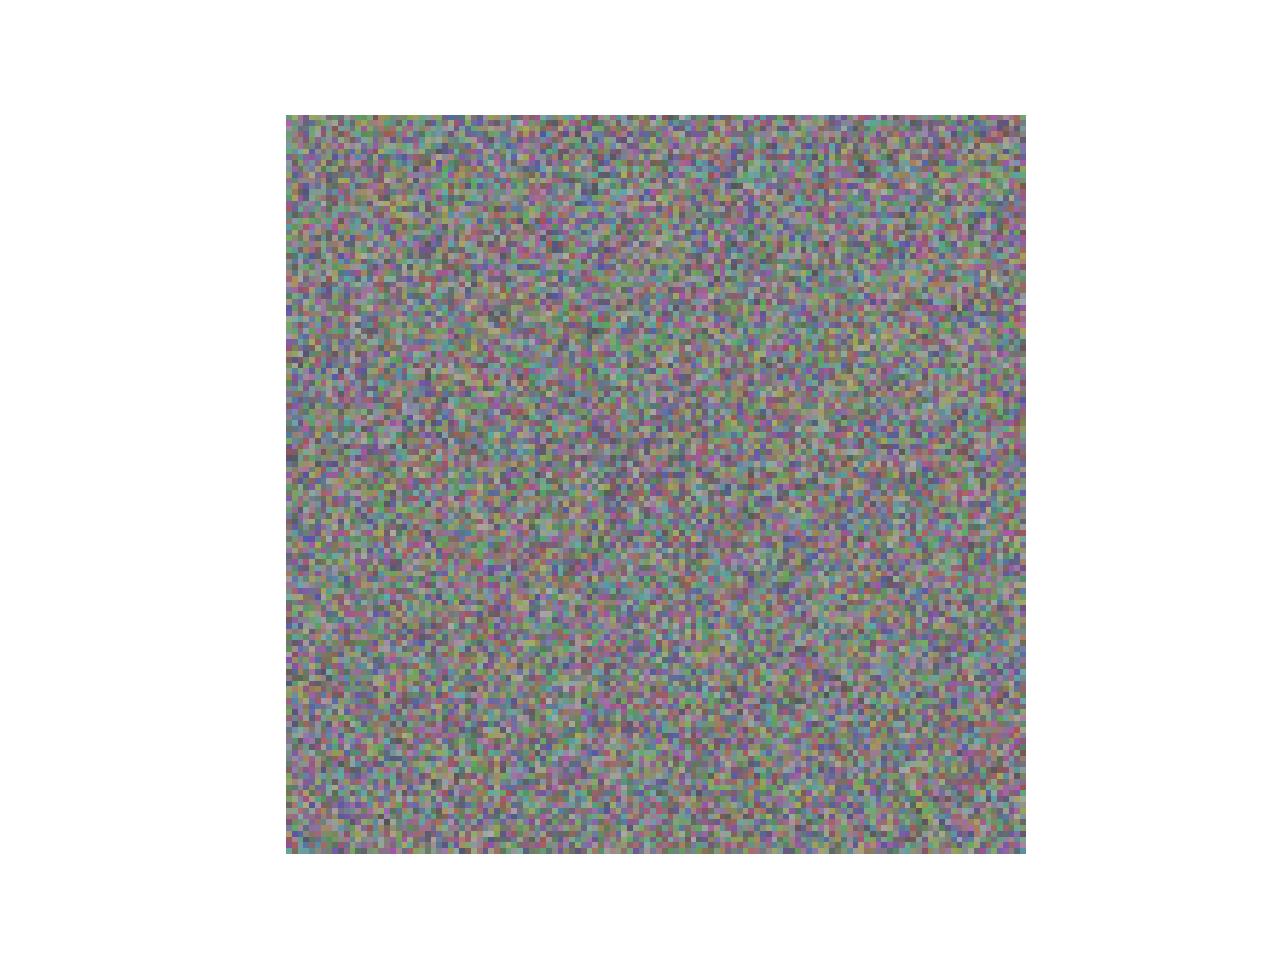

In [12]:
plt.axis('off')
plt.imshow(deprocess_image(generate_random_image()[0]))

### Define optimization objective

We are going to take a look into the 3rd filter of the 5th layer:

In [13]:
layer_nr = 4
filter_nr = 2

Neural network's placeholder for layer's tensor:

In [14]:
layer_output = layer_dict[layer_names[layer_nr]].output

Define the "loss" as being the average value of the desired filter in the selected layer

In [15]:
loss = K.mean(layer_output[:, :, :, filter_nr])

Compute the gradient of the input picture with respoct to this loss, *i.e.* the direction in which we can vary the input image in order to increase or decrease the "loss"

In [16]:
grads = K.gradients(loss, input_img)[0]

Normalize the gradients

In [17]:
def normalize_grad(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [18]:
grads = normalize_grad(grads)

Function that returns the loss and gradients given the input picture

In [19]:
iterate = K.function([input_img], [loss, grads])

For a given number of iterations, modify the input image so we increase the activation at the desired filter:

In [20]:
input_img_data = generate_random_image()

Define a function that performs the iterative process of modifying the input image to maximize the "loss"

In [21]:
def iterate_img_gen(input_data, iterate_fn, step_size, steps=20, verbose=False):
    for i in range(steps):
        # compute the loss_value and the gradient
        loss_value, grads_value = iterate_fn([input_data])
        # modify the input image in the direction that maximizes the loss (positive gradient)
        input_data += grads_value * step_size
        if verbose:
            print(loss_value)
    return input_data

In [22]:
step = 1.
output_img_data = iterate_img_gen(input_img_data, iterate, step)

<IPython.core.display.Javascript object>


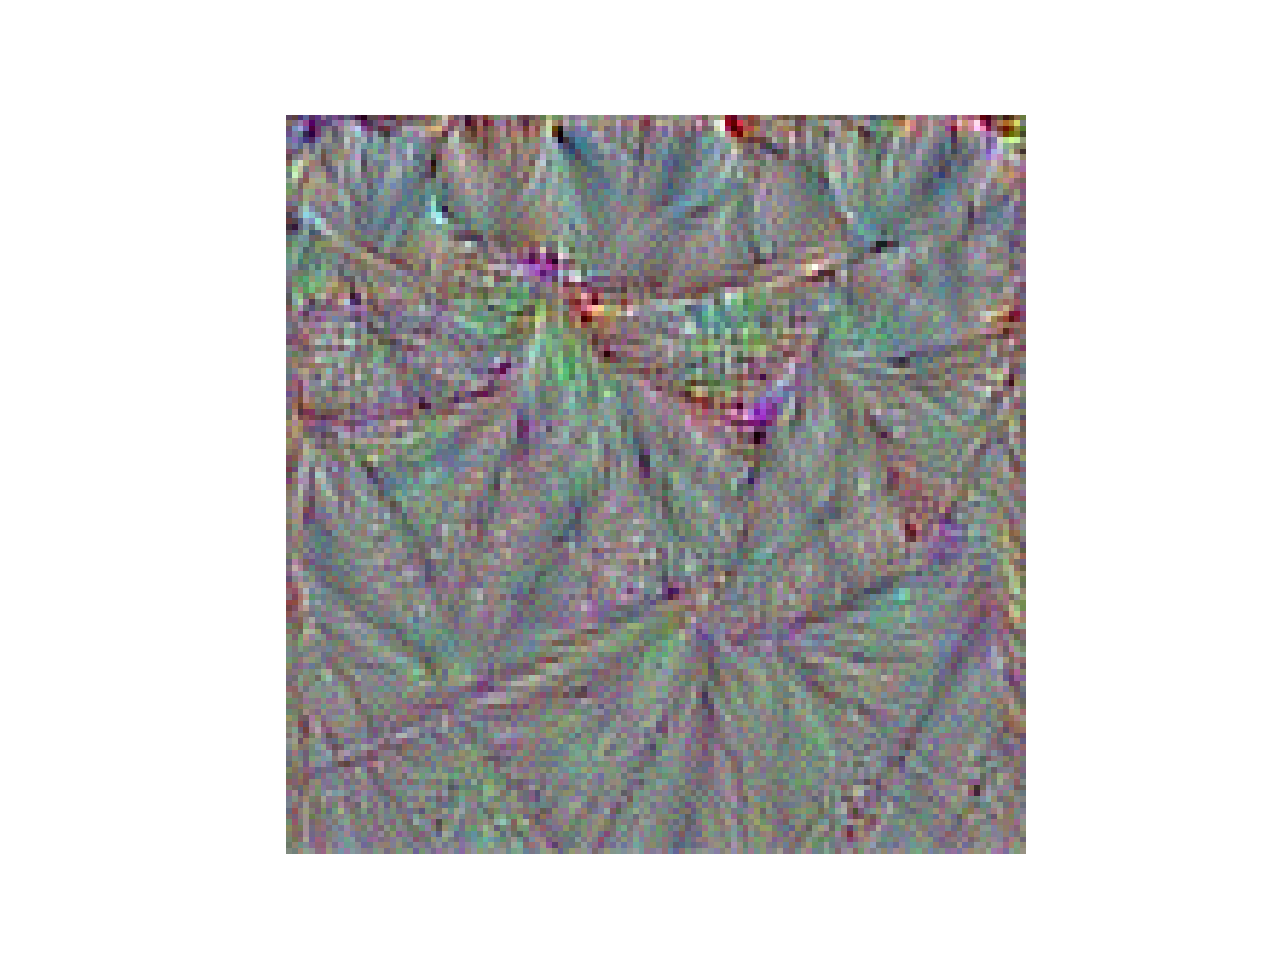

In [23]:
plt.figure()
plt.axis('off')
plt.imshow(deprocess_image(output_img_data[0]))

<img src="https://blog.keras.io/img/vgg16_filters_overview.jpg">

## 2nd Task: Finding an input that maximizes a specific class

In [24]:
model = applications.VGG16(include_top=True,
                           weights='imagenet')

[ImageNet Labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

#### What is the NN understanding of a Sea Snake?

In [25]:
sea_snake_idx = 65 # sea snake

Function that returns a function that performs the same iterative process as above, but for tweaking based on the output layer:

In [26]:
def proc_maximize_class(model, class_index):
    # get reference to the model's input, where the image is fed
    input_img = model.input
    # define the loss as the mean activation at the output index
    loss = model.output[:, class_index]
    # compute the direction of change in the input image that affects the output index
    grads = K.gradients(loss, input_img)[0]
    grads = normalize_grad(grads)
    # define our function, that receives as input an image, and outputs the loss and gradient
    iterate = K.function([input_img], [loss, grads])
    return iterate

In [27]:
iterate = proc_maximize_class(model, sea_snake_idx)

We start off with a random image once again:

In [28]:
input_img_data = generate_random_image(224, 224)

an perform the iterative changes on it

("loss" comes from a softmax, so it corresponds directly to a probability)

In [29]:
step = 7
output_img_data = iterate_img_gen(input_img_data, iterate, step, steps=30, verbose=True)

[ 0.00036052]
[ 0.00038486]
[ 0.00041291]
[ 0.00044663]
[ 0.0004869]
[ 0.00053691]
[ 0.00060015]
[ 0.00067835]
[ 0.00078338]
[ 0.00093884]
[ 0.00122228]
[ 0.00183383]
[ 0.00418957]
[ 0.01509075]
[ 0.0402018]
[ 0.06982122]
[ 0.75141001]
[ 0.01655796]
[ 0.95791399]
[ 0.99968421]
[ 0.99972385]
[ 0.99975413]
[ 0.99977762]
[ 0.99979645]
[ 0.99981207]
[ 0.9998253]
[ 0.99983644]
[ 0.99984574]
[ 0.99985433]
[ 0.99986196]


<IPython.core.display.Javascript object>


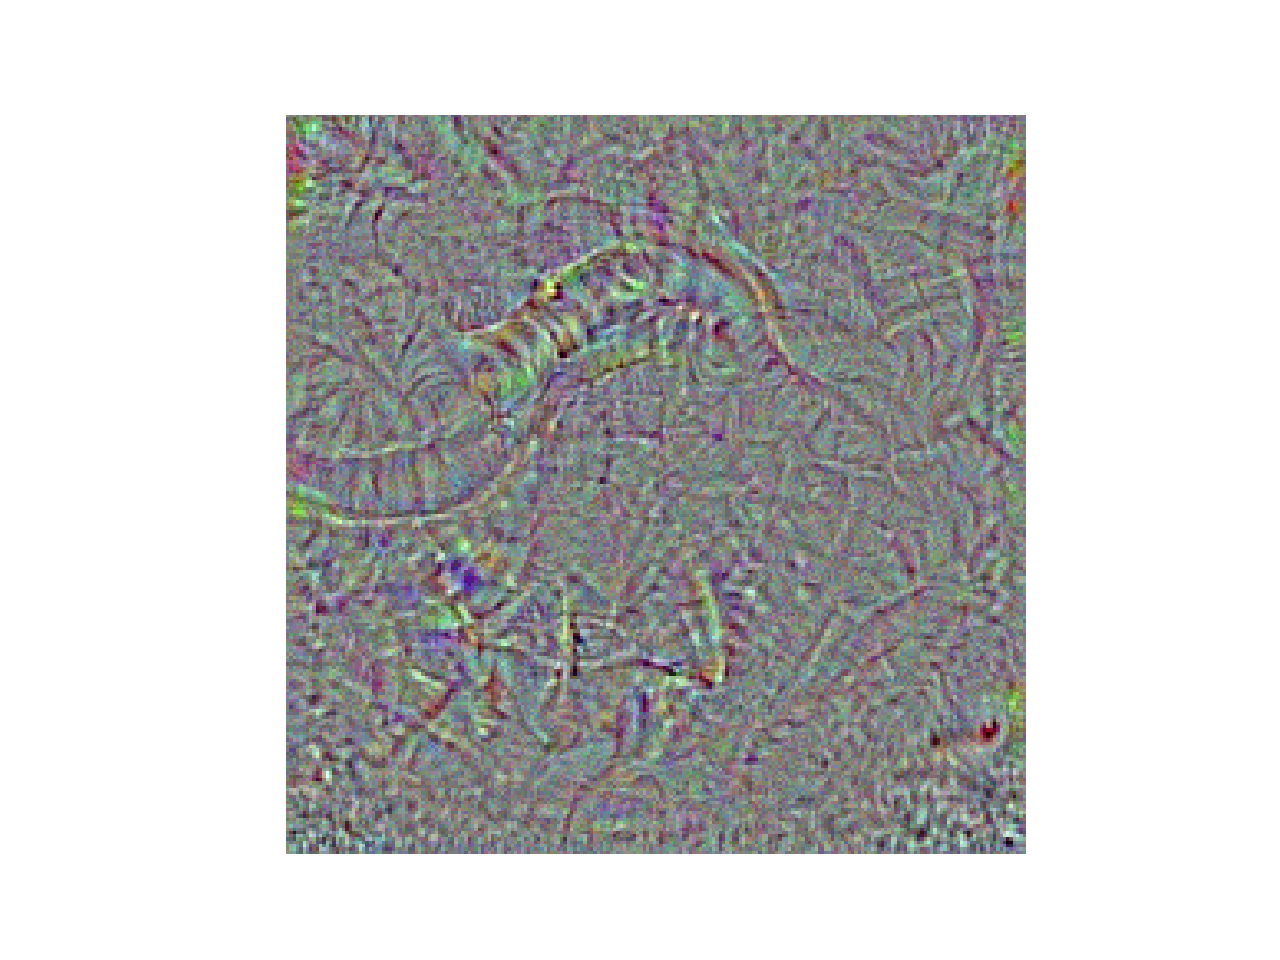

In [30]:
plt.figure()
plt.axis('off')
plt.imshow(deprocess_image(input_img_data[0]))

<img src="https://i.imgflip.com/1rybxs.jpg" title="made at imgflip.com"/>

## 3rd Task: What would a Mona Lisa in the Cretaceous period look like?

In [31]:
from PIL import Image
import requests
from io import BytesIO

url for the image

In [32]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'

Useful function to prepare a new image to be fed to the network:

In [33]:
def normalize_img(x):
    x = np.copy(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    return x

In [34]:
response = requests.get(url)
mona_lisa_img = Image.open(BytesIO(response.content))

<IPython.core.display.Javascript object>


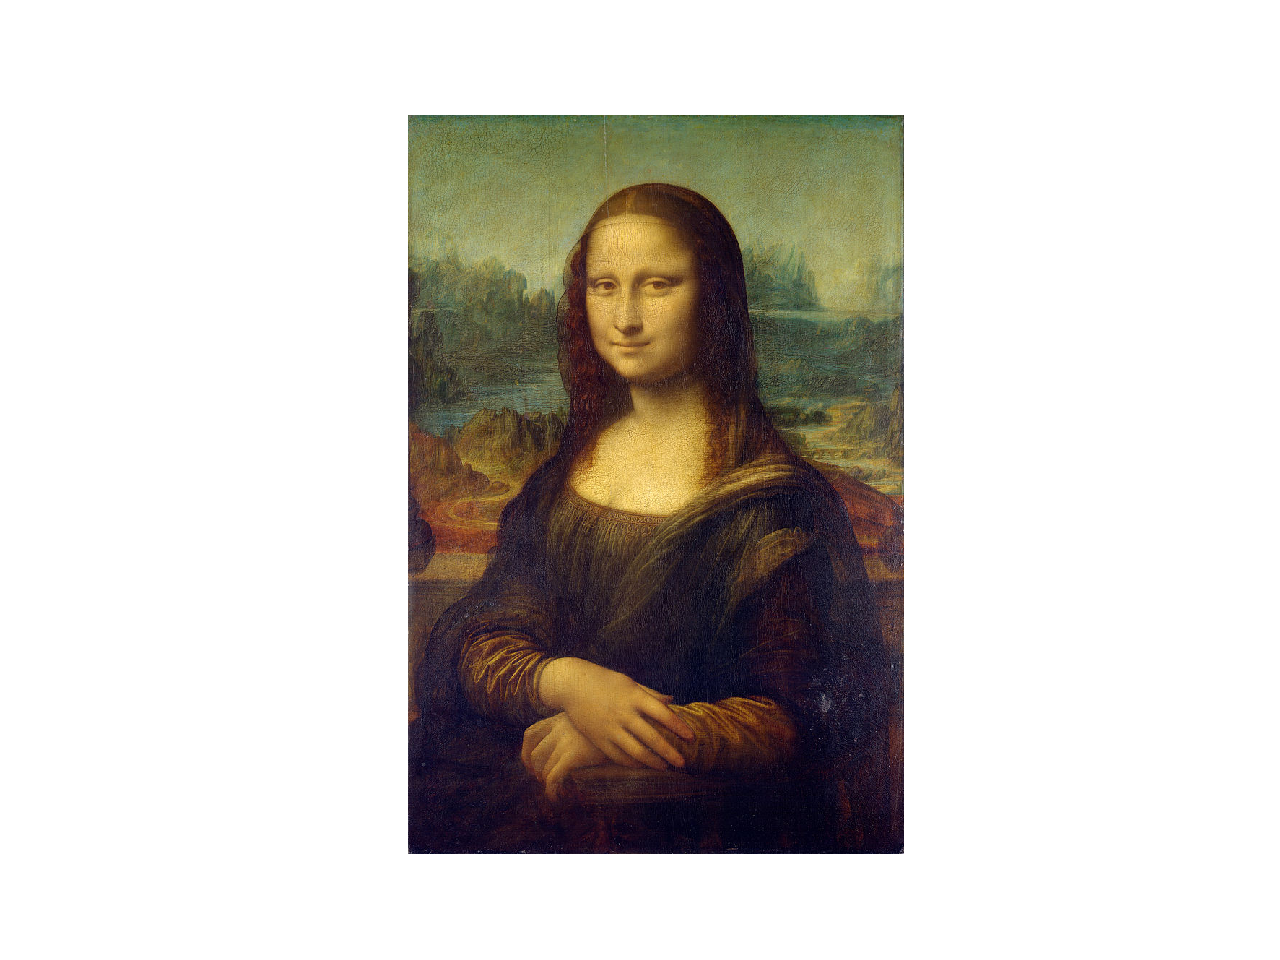

In [35]:
plt.figure()
plt.axis('off')
plt.imshow(mona_lisa_img)

In [36]:
img_width = 224
img_height = 224

Resize the image to the desired length:

In [37]:
mona_lisa_img.thumbnail((img_width, 500), Image.ANTIALIAS)
mona_lisa_img = mona_lisa_img.crop((0, 0, img_width, img_height))

In [38]:
mona_lisa_img_data = np.array(mona_lisa_img).astype(np.float32) / 256.
mona_lisa_img_data = mona_lisa_img_data.reshape((1,) + mona_lisa_img_data.shape)

<IPython.core.display.Javascript object>


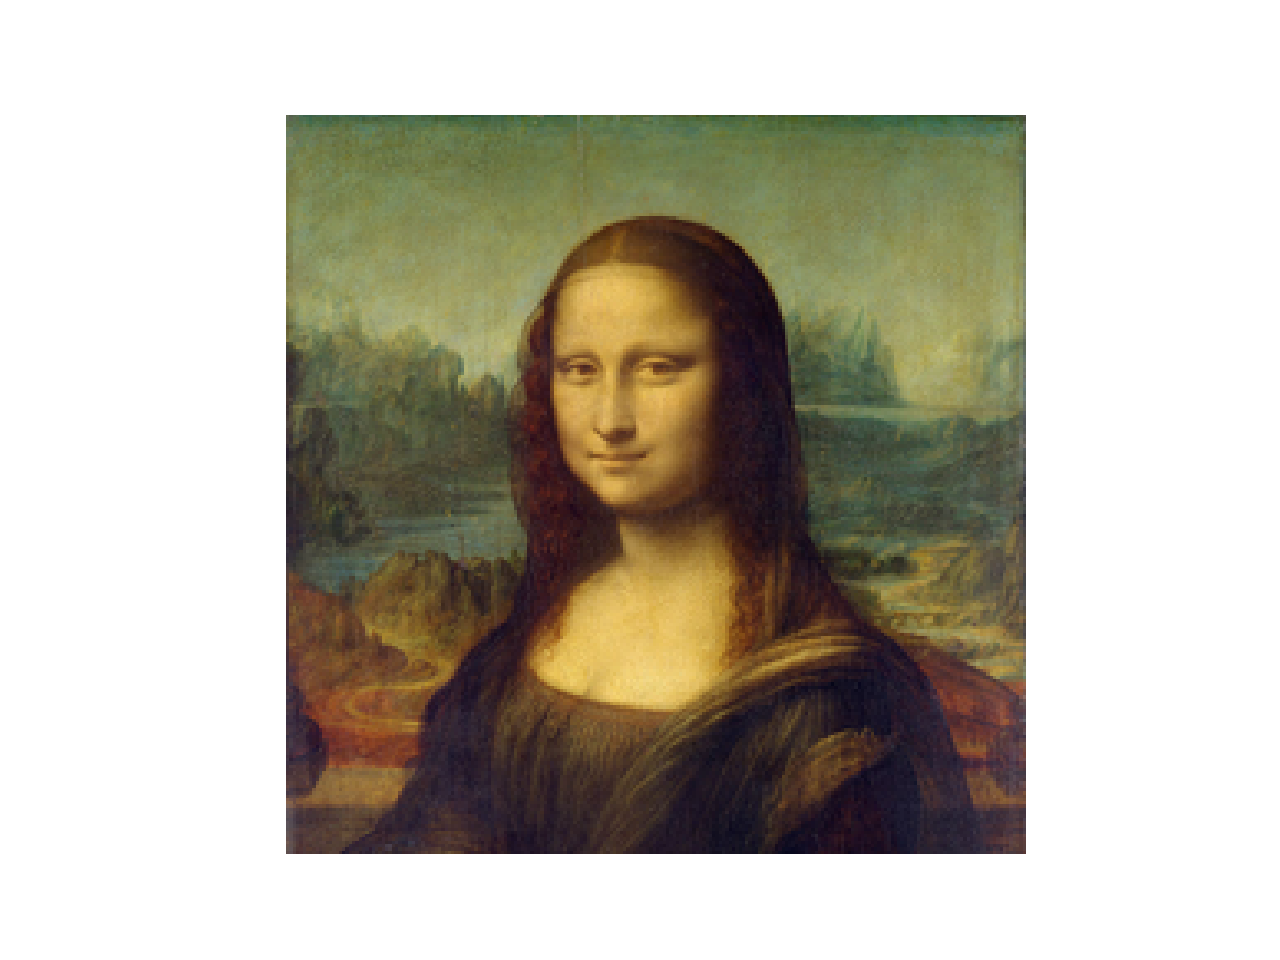

In [39]:
plt.figure()
plt.axis('off')
plt.imshow(mona_lisa_img_data[0])

In [40]:
triceratops_idx = 51 # 'triceratops'

In [41]:
iterate = proc_maximize_class(model, triceratops_idx)

In [42]:
step = 0.01
mona_lisa_img_data = normalize_img(mona_lisa_img_data)
mona_lisa_img_data = iterate_img_gen(mona_lisa_img_data, iterate, step, steps=30, verbose=True)

[ 0.0002078]
[ 0.00021966]
[ 0.00023331]
[ 0.00024867]
[ 0.00026572]
[ 0.00028482]
[ 0.00030766]
[ 0.00033368]
[ 0.00036528]
[ 0.00040095]
[ 0.00044228]
[ 0.00049062]
[ 0.00054549]
[ 0.00061162]
[ 0.00069382]
[ 0.00079875]
[ 0.00093937]
[ 0.00113052]
[ 0.0014141]
[ 0.00183875]
[ 0.002494]
[ 0.00346973]
[ 0.00496041]
[ 0.00738108]
[ 0.0099116]
[ 0.0141046]
[ 0.02148734]
[ 0.02460985]
[ 0.04432695]
[ 0.04807688]


<IPython.core.display.Javascript object>


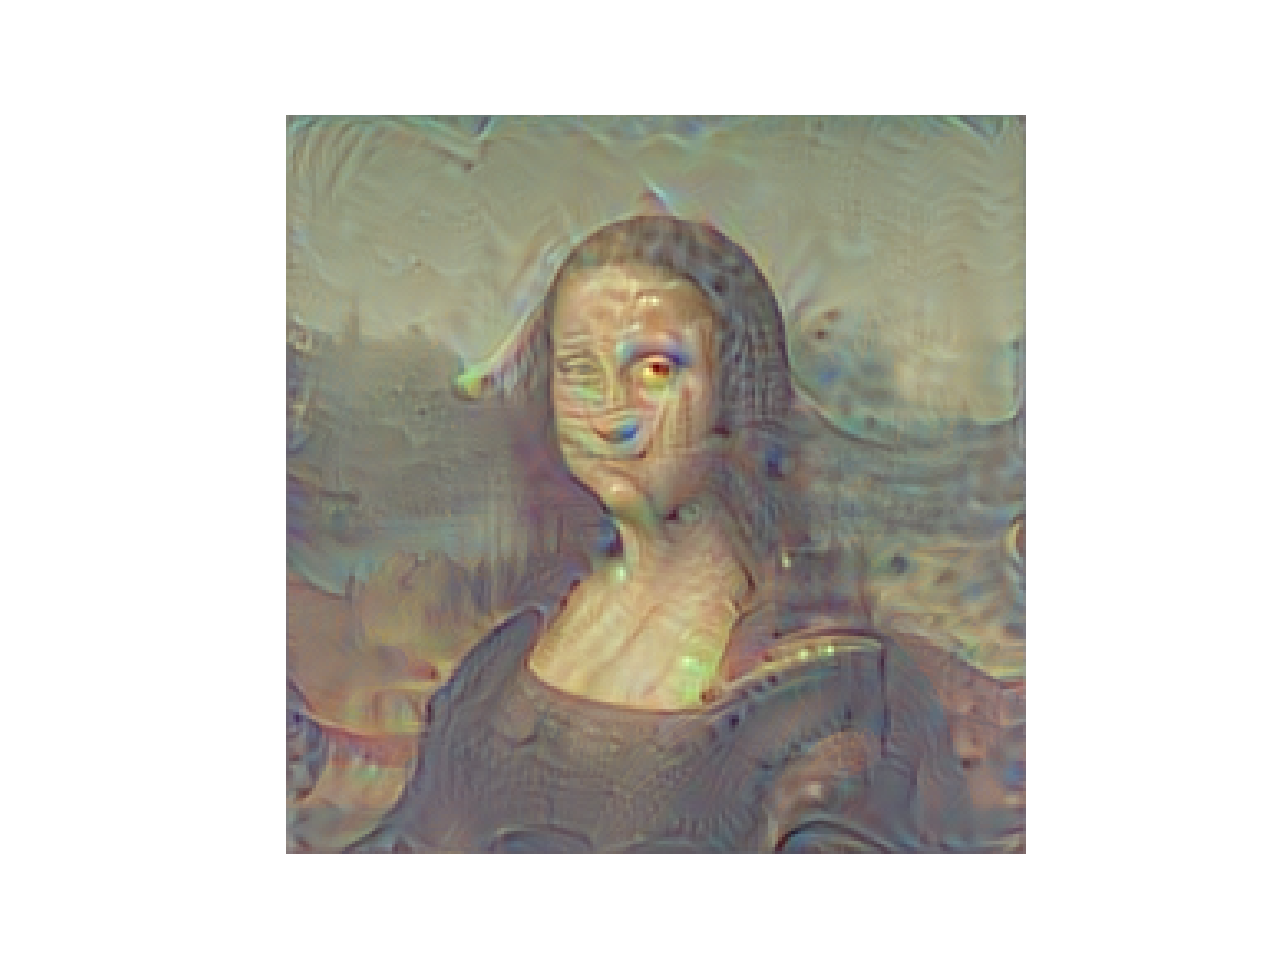

In [43]:
plt.figure()
plt.axis('off')
plt.imshow(deprocess_image(mona_lisa_img_data[0]))

In [44]:
mona_lisa_img_data = iterate_img_gen(mona_lisa_img_data, iterate, step, steps=30, verbose=True)

[ 0.08363685]
[ 0.09344733]
[ 0.17377682]
[ 0.19889894]
[ 0.31879014]
[ 0.34853044]
[ 0.48452431]
[ 0.56449574]
[ 0.66421646]
[ 0.73316491]
[ 0.80259776]
[ 0.84218049]
[ 0.88843703]
[ 0.91110528]
[ 0.93544722]
[ 0.94404191]
[ 0.95971471]
[ 0.96806127]
[ 0.97598797]
[ 0.98042828]
[ 0.98477018]
[ 0.98737538]
[ 0.98960924]
[ 0.99122566]
[ 0.99265701]
[ 0.99375254]
[ 0.99467045]
[ 0.99524081]
[ 0.99570483]
[ 0.99607998]


<IPython.core.display.Javascript object>


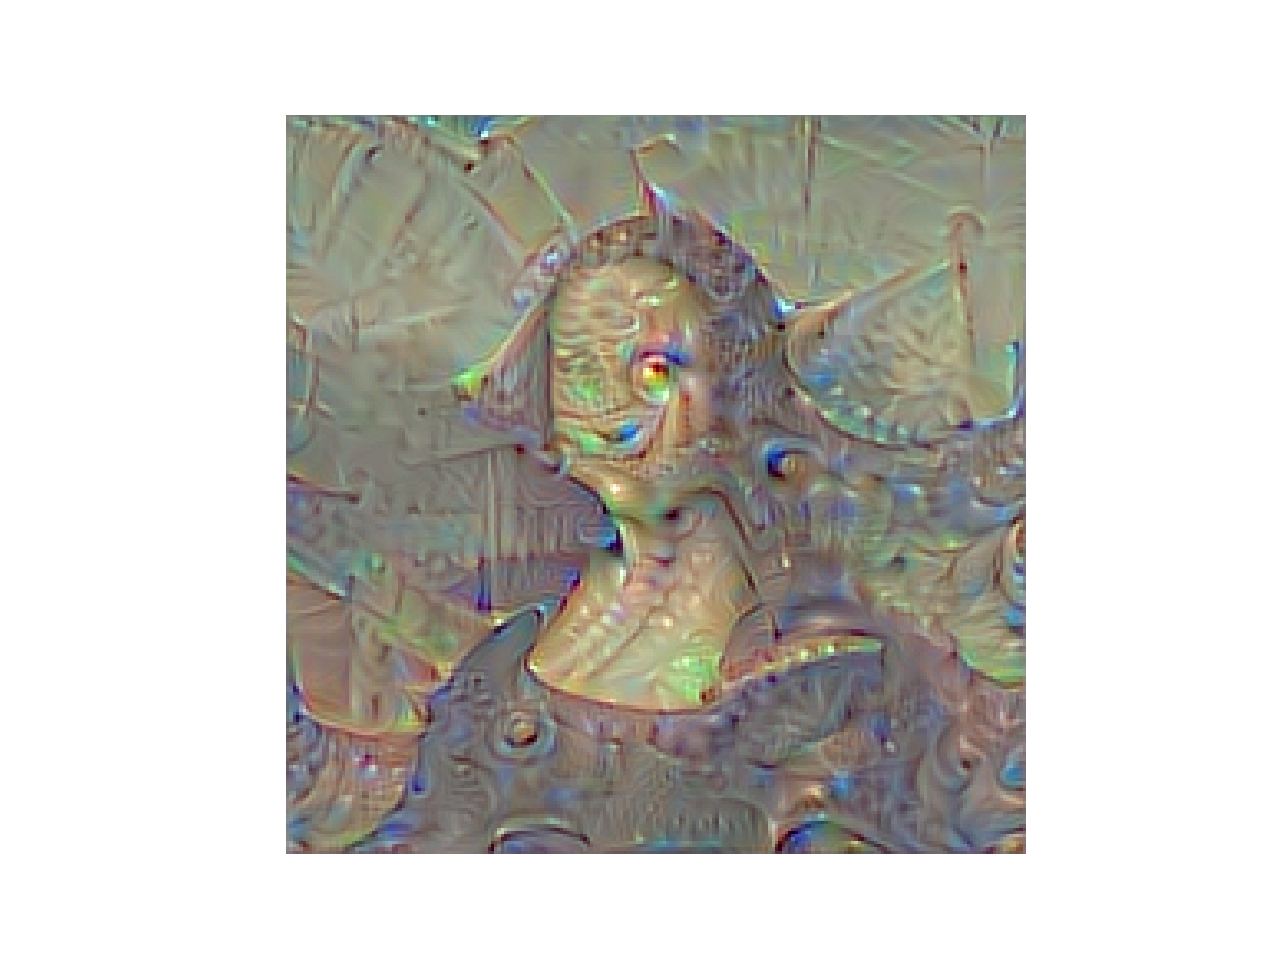

In [45]:
plt.figure()
plt.axis('off')
plt.imshow(deprocess_image(mona_lisa_img_data[0]))

# Adversarial Examples

### Are we able to detect the irregularities in adversarial examples?

<img src="https://blog.openai.com/content/images/2017/02/adversarial_img_1.png">

<img src="http://cleverhans.io/assets/adversarial-example-crossing-decision-boundary.png">

### What if the data is not digital?

<img src="https://blog.openai.com/content/images/2017/02/adversarial_img_2.png">

### How can we defend?

 * **Adversarial Training (brute force)**: generate adversarial examples and train the model on the true label (example [here](https://github.com/tensorflow/cleverhans/blob/master/tutorials/mnist_tutorial_tf.md)).
 * **[Defensive distilation](https://arxiv.org/abs/1511.04508)**: train a model on the hard labels, and train a second model on outputting the probabilities given by the first (smooths the decision surface).

### What if the model is available only as a black-box (i.e. *gradient masking* in NN)?

 * A *substitute* model that learns to mimic the decision boundaries of the *oracle* one is able to [bypass the problem](https://arxiv.org/abs/1602.02697) - **Transferability of adversarial examples**
 * Other strategies are possible: 
   * [Evolutionary Algorithms](https://arxiv.org/abs/1412.1897) with mutations on compositional patterns level;
   * [Poisoning training sets](https://www.theverge.com/2016/3/24/11297050/tay-microsoft-chatbot-racist)
   * ...

<img src="https://adriancolyer.files.wordpress.com/2017/02/dnn-fooling-fig-14.jpeg?w=960", style="margin-bottom: -510px">

### Is there hope?

> *Testing shows the presence, not the absence of bugs*
>                       - Edsger Dijkstra

<img src="http://cleverhans.io/assets/testing-verification.gif">

# Bibliography 

 * [OpenAI blog post](https://blog.openai.com/adversarial-example-research/)
 * [CleverHans blog](http://www.cleverhans.io/) and [software](https://arxiv.org/abs/1610.00768)
 * [Morning Paper blog post on "When DNNs go wrong – adversarial examples and what we can learn from them"](https://blog.acolyer.org/2017/02/28/when-dnns-go-wrong-adversarial-examples-and-what-we-can-learn-from-them/)
 * [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)
 * [Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks](https://arxiv.org/abs/1511.04508)
 * [Defensive Distillation is Not Robust to Adversarial Examples](https://arxiv.org/abs/1607.04311)
 * [Practical Black-Box Attacks against Machine Learning](https://arxiv.org/abs/1602.02697)
 * [Towards the Science of Security and Privacy in Machine Learning](https://arxiv.org/abs/1611.03814)
 * [Deep Neural Networks are Easily Fooled: High Confidence Predictions for Unrecognizable Images](https://arxiv.org/abs/1412.1897)
 * [Adversarial examples in the physical world](https://arxiv.org/abs/1607.02533)
 * [Membership Inference Attacks against Machine Learning Models](https://arxiv.org/abs/1610.05820)